## Y-Factor Analysis of Test 1 and 2 

In [143]:
import numpy as np
from openpyxl import load_workbook
wb = load_workbook(filename = 'RF_noise_measurement_Jan_Feb.xlsx')
sheet = wb.active

A = np.array([[i.value for i in j[1:5]] for j in sheet.rows])
B = np.array([[i.value for i in j[6:9]] for j in sheet.rows])

A = np.delete(A,0,0)
B = np.delete(B,0,0)

A = 10**(A/10)
B = 10**(B/10)

TempsA = np.array([13.1,27.6,40.9,56])
TempsB = np.array([28,56,78])


AvgA = np.empty([2,4])
AvgB = np.empty([2,3])
i=0
while i < 4: 
    AvgA[0,i] = np.mean(A[:,i])
    AvgA[1,i] = np.std(A[:,i])/(A.shape[0])**.5
    i+=1
    
i=0
while i < 3:    
    AvgB[0,i] = np.mean(B[:,i])
    AvgB[1,i] = np.std(B[:,i])/(B.shape[0])**.5
    i+=1

print("Relative Uncertainity in Power:", np.mean(AvgA[1]/AvgA[0]))

Relative Uncertainity in Power: 0.05151482176088753


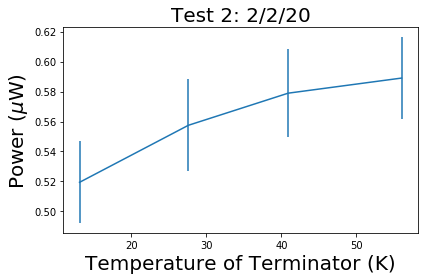

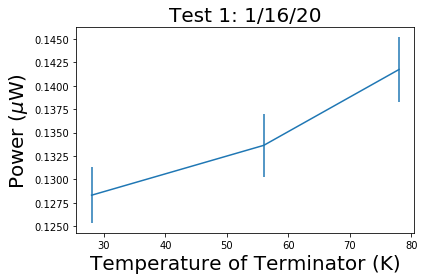

In [139]:
###### %matplotlib inline  
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages


ppA = PdfPages('PlotA.pdf')
ppB = PdfPages('PlotB.pdf')

figA, axA = plt.subplots(1, figsize=(6,4))
plt.errorbar(TempsA, AvgA[0]*1000, yerr=AvgA[1]*1000, label='both limits (default)')  # Test plots
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('Temperature of Terminator (K)', fontsize = 20)
plt.ylabel('Power ($\mu$W)', fontsize = 20)
plt.title("Test 2: 2/2/20", fontsize = 20)
# plt.legend(('2/2/20',),loc='upper left')

plt.tight_layout()
ppA.savefig(figA) 
plt.show()

figB, axB = plt.subplots(1, figsize=(6,4))
plt.errorbar(TempsB, AvgB[0]*1000,yerr=AvgB[1]*1000, label='both limits (default)')  # Test plots
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('Temperature of Terminator (K)', fontsize = 20)
plt.ylabel('Power ($\mu$W)', fontsize = 20)
plt.title("Test 1: 1/16/20",fontsize = 20)
# plt.legend(('1/16/20',),loc='upper left')

plt.tight_layout()
ppB.savefig(figB) 
plt.show()


ppA.close()
ppB.close()

In [179]:
import matplotlib.pyplot as plt
from scipy import stats

slopeA, interceptA, r_valueA, p_valueA, std_errA = stats.linregress(TempsA, AvgA[0])
slopeB, interceptB, r_valueB, p_valueB, std_errB = stats.linregress(TempsB, AvgB[0])
print("slope: %f    intercept: %f" % (slopeB, interceptB))
print(std_errA)


k_b = 1.38064852 *10**-23 # Boltzman Constant
B = 5*10**6

# T_e = intercept*10**-3 /(k_b*5*10**6)
# print(T_e)   # this doesn't really work because you need to know the gain... 

def N_A(T):
    return slopeA*T+interceptA

def N_B(T):
    return slopeB*T+interceptB
print(interceptA/slopeA)
print(interceptB/slopeB)

print(10*np.log10(slopeA/(k_b*B)))

# Getting T_e with Y-factor measurement:

Y_A = N_A(56)/N_A(13)
Y_B = N_B(78)/N_B(28)
T_e_A = (56- 13*(Y_A))/(Y_A-1)
T_e_B = (78- 28*(Y_B))/(Y_B-1)
print('Effective temperature of our RF system, test 1',T_e_B)
print('Effective temperature of our RF system, test 2',T_e_A)

#Getting the gain: 
def G_A(T):
    return N_A(T)/(k_b*B*(T+T_e_A))
def G_B(T):
    return N_B(T)/(k_b*B*(T+T_e_B))
print('Gain predicted by Y-Factor Method test1 in dB:',10*np.log10(G_B(66)))  # the gain (temp independent) in dB. 
print('Gain predicted by Y-Factor Method test2 in dB:',10*np.log10(G_A(66)))

slope: 0.000000    intercept: 0.000120
3.2255293199003903e-07
312.5496794283303
453.26695034895357
103.69802193523591
Effective temperature of our RF system, test 1 453.26695034895397
Effective temperature of our RF system, test 2 312.54967942833036
Gain predicted by Y-Factor Method test1 in dB: 95.84645716459683
Gain predicted by Y-Factor Method test2 in dB: 103.69802193523591


In [141]:
# Now to get this to work with uncertainties: 
# Notes: 
# Need to tool around with absolute_sigma. After a bit of thought I think it should be at "true". 
from scipy.optimize import curve_fit

k_b = 1.38064852 *10**-23 # Boltzman Constant
B = 5*10**6               # Fieldfox bandwidth

def linfunc(x, m, b):
    return m*x + b 

poptA, pcovA = curve_fit(linfunc,TempsA,AvgA[0], (.000002,.000506), AvgA[1],True)
poptB, pcovB = curve_fit(linfunc,TempsB,AvgB[0], (.000002,.000106), AvgB[1],True)

perrA = np.sqrt(np.diag(pcovA))
perrB = np.sqrt(np.diag(pcovB))

# Effective Noise Temperatures from test1 (B) and test2 (A) w/ error propigation
#Note: Should look at off diagonal elements and see how big they are. 

T_A = poptA[1]/poptA[0]
T_B = poptB[1]/poptB[0]
T_A_err = (T_A)*((perrA[0]/poptA[0])**2 + (perrA[1]/poptA[1])**2 +pcovA[1,0]/(poptA[0]*poptA[1]) )**.5   
T_B_err = (T_B)*((perrB[0]/poptB[0])**2 + (perrB[1]/poptB[1])**2 +pcovB[1,0]/(poptB[0]*poptB[1]) )**.5
# Note the tricky sign here. The variables are anticorrelated so the uncertainty in T_e should decrease when you include the cross terms. 


print("test 1 T_e =", T_B,'+-',T_B_err)
print("test 2 T_e =",T_A,'+-',T_A_err)
# Calculated Gain G 

G_A = 10*np.log10(poptA[0]/(k_b*B))
G_B = 10*np.log10(poptB[0]/(k_b*B))

G_A_err = 10*np.log10(perrA[0]/(k_b*B))
G_B_err = 10*np.log10(perrB[0]/(k_b*B)) 


print("test 1 Gain =",G_B,'+-',G_B_err)
print("test 2 Gain =",G_A,'+-',G_A_err)

test 1 T_e = 460.99943163211054 +- 153.2494390187301
test 2 T_e = 310.98894031693294 +- 159.20567426135133
test 1 Gain = 95.78119053246907 +- 91.22011061309274
test 2 Gain = 103.71253801201254 +- 101.02332719308978


## Analysis of 3rd test

Notes on the Measurement: 
* We were looking at the reflected noise coming back from the two aligned quarter wave plates. 
* We took multiple measurements at each temp to see if there was drift and if the averaging would get rid of uncertainty in the noise power.
* We took n = (9, 16, 16) individual noise measurements at T = (13, 26, 37) K.
* It seemed that the heater was not well coupled to the terminator. We needed more power than for the previous tests to heat the terminator. Also the amplifier temperature did not increase as much as one would expect based on the amount of power we put on the terminator heater. We should be careful to tighten crucial contacts after warming the system. 



In [190]:
import numpy as np
from openpyxl import load_workbook
test3_wb = load_workbook(filename = 'RF_noise_measurement3_03122020.xlsx')
sheet = test3_wb.active

T13 = np.array([[i.value for i in j[0:10]] for j in sheet.rows], dtype=np.float64)
T26 = np.array([[i.value for i in j[10:26]] for j in sheet.rows], dtype=np.float64)
T37 = np.array([[i.value for i in j[26:42]] for j in sheet.rows], dtype=np.float64)

freqs = T13[:,0]
freqs = np.delete(freqs,0)

T13 = np.delete(T13,0,0)
T13 = np.delete(T13,0,1)
T26 = np.delete(T26,0,0)
T37 = np.delete(T37,0,0)

In [191]:
# Now we take averages of arrays and across arrays. 

# Converting from dBm to mW 

T13 = 10**(T13/10)
T26 = 10**(T26/10)
T37 = 10**(T37/10)

# Means for T_t = 13,26,37 K. Note that Ax0 is the frequency axis and Ax1 is the n (test #) axis. 



mean13ax0 = np.mean(T13,axis =0)
std13ax0 =  np.std(T13,axis =0)
mean13ax1 = np.mean(T13,axis =1) 
std13ax1 = np.std(T13,axis =1)

mean26ax0 = np.mean(T26,axis =0)
std26ax0 =  np.std(T26,axis =0)
mean26ax1 = np.mean(T26,axis =1) 
std26ax1 = np.std(T26,axis =1)

mean37ax0 = np.mean(T37,axis =0)
std37ax0 =  np.std(T37,axis =0)
mean37ax1 = np.mean(T37,axis =1) 
std37ax1 = np.std(T37,axis =1)

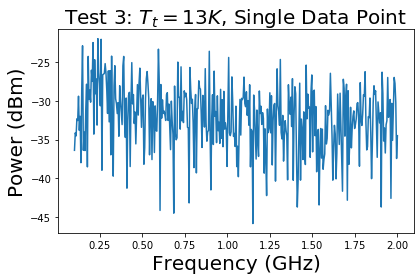

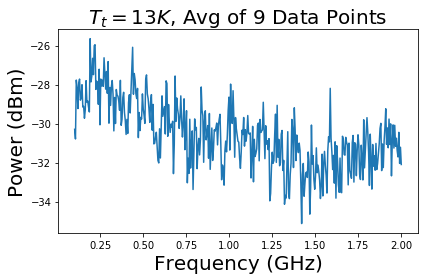

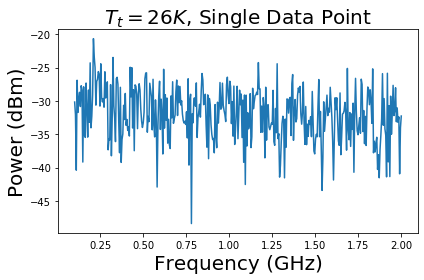

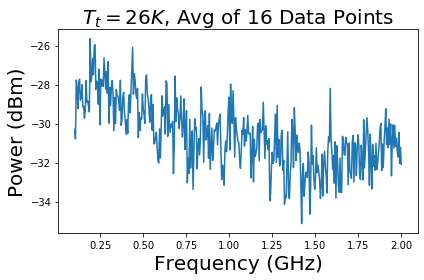

In [194]:
# Plots showing effect of averaging. 

# Note that the averaging must be done in mW not dBm. 
%matplotlib inline  
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

figA, axA = plt.subplots(1, figsize=(6,4))
axA.plot(freqs/(10**9),10*np.log10(T13[:,1]))  # Test plots
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('Frequency (GHz)', fontsize = 20)
plt.ylabel('Power (dBm)', fontsize = 20)
plt.title("Test 3: $T_t = 13K$, Single Data Point" , fontsize = 20)
plt.tight_layout()
plt.show()


figB, axB = plt.subplots(1, figsize=(6,4))
plt.plot(freqs/(10**9),10*np.log10(np.mean(T26,axis =1)))  # Test plots
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('Frequency (GHz)', fontsize = 20)
plt.ylabel('Power (dBm)', fontsize = 20)
plt.title("$T_t = 13K$, Avg of 9 Data Points", fontsize = 20)
plt.tight_layout()
plt.show()

figC, axC = plt.subplots(1, figsize=(6,4))
plt.plot(freqs/(10**9),10*np.log10(T26[:,1]))  # Test plots
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('Frequency (GHz)', fontsize = 20)
plt.ylabel('Power (dBm)', fontsize = 20)
plt.title("$T_t = 26K$, Single Data Point", fontsize = 20)
plt.tight_layout()
plt.show()

figD, axD = plt.subplots(1, figsize=(6,4))
plt.plot(freqs/(10**9),10*np.log10(np.mean(T26,axis =1)))  # Test plots
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('Frequency (GHz)', fontsize = 20)
plt.ylabel('Power (dBm)', fontsize = 20)
plt.title("$T_t = 26K$, Avg of 16 Data Points", fontsize = 20)
plt.tight_layout()
plt.show()

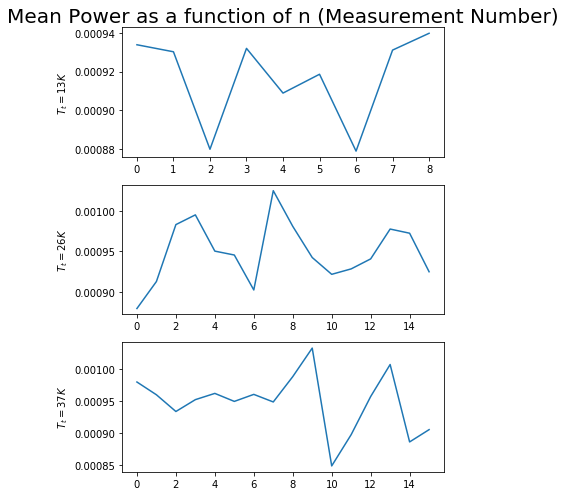

In [147]:
%matplotlib inline  
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages


# ppA = PdfPages('PlotA.pdf')
# ppB = PdfPages('PlotB.pdf')

fig, ax = plt.subplots(3, figsize=(7,7))
# fig.suptitle('Vertically stacked subplots', fontsize = 20)
ax[0].plot(mean13ax0)  
ax[0].set_title('Mean Power as a function of n (Measurement Number)', fontsize = 20)
ax[0].set(ylabel = '$T_t = 13 K $')
ax[1].plot(mean26ax0)
ax[1].set(ylabel = '$T_t = 26 K $')
ax[2].plot(mean37ax0)
ax[2].set(ylabel = '$T_t = 37 K $')


# for axis in ax.flat:
#     axis.set(ylabel= 'Test{}'.format(axis))
# axA[1].plot(freqs/(10**9),10**(T13[:,1]/10))
# plt.tick_params(axis='both', which='major', labelsize=10)
# plt.xlabel('Frequency (GHz)', fontsize = 20)
# plt.ylabel('Power (dBm)', fontsize = 20)
# plt.title("Test 3: $T_t = 13K$, Single Data Point" , fontsize = 20)
# # plt.legend(('2/2/20',),loc='upper left')

plt.tight_layout()
# ppA.savefig(figA) 
plt.show()

In [183]:
# Creating arrays to perform Y-factor Measurement on: 

Temps = np.array([13,26,37])

Avgs = np.empty([2,3])
Avgs[:,0] = [np.mean(mean13ax1), np.std(mean13ax1)/((mean13ax1.shape[0])**.5)]
Avgs[:,1] = [np.mean(mean26ax1), np.std(mean26ax1)/((mean26ax1.shape[0])**.5)]
Avgs[:,2] = [np.mean(mean37ax1), np.std(mean37ax1)/((mean37ax1.shape[0])**.5)]


## What is going on?

* I am taking each of the measurements done at a certain temperature (9,16,16 respectively) and averaging across measurements (adding them up and dividing by the number of measurements). This give me a 401 element array of powers. I then take the mean and std/(401^.5) to give me a power with an associated uncertainty. 

* Why does this not gain me much in relative uncertainty? 

In [182]:
# Average relative uncertainty for each individual power spectra for T_t = 26: 
print("The average relative uncertainty for the 16 individual power spectra taken at T = 26 K: ",((np.mean(np.std(T26,1)))/(T26.shape[0])**.5)/np.mean(np.mean(T26,1)))

print("so I would expect for the combined uncertainty (divide by 4): ", ((np.mean(np.std(T26,1)))/(T26.shape[0])**.5)/np.mean(np.mean(T26,1))/4  )

print("But doing it my way I get an Average relative uncertainty in power for T = 26 K :", (Avgs[1]/Avgs[0])[1])

print("I'm only getting a power of 2 here as opposed to 4... Perhaps this is due to the variation in frequency.")







The average relative uncertainty for the 16 individual power spectra taken at T = 26 K:  0.03897783201788609
so I would expect for the combined uncertainty (divide by 4):  0.009744458004471523
But doing it my way I get an Average relative uncertainty in power for T = 26 K : 0.0206473667001483
I'm only getting a power of 2 here as opposed to 4... Perhaps this is due to the variation in frequency.


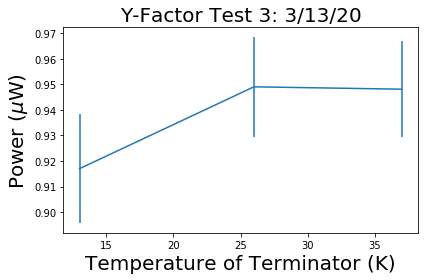

In [114]:
# Plot of results of 3rd Test: 

%matplotlib inline  
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages


fig, ax = plt.subplots(1, figsize=(6,4))
plt.errorbar(Temps, Avgs[0]*1000, yerr=Avgs[1]*1000, label='both limits (default)')  # Test plots
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('Temperature of Terminator (K)', fontsize = 20)
plt.ylabel('Power ($\mu$W)', fontsize = 20)
plt.title("Y-Factor Test 3: 3/13/20", fontsize = 20)
# plt.legend(('2/2/20',),loc='upper left')

plt.tight_layout() 
plt.show()

In [136]:
# Y-factor Measurement 

from scipy.optimize import curve_fit

k_b = 1.38064852 *10**-23 # Boltzman Constant
B = 5*10**6               # Fieldfox bandwidth

def linfunc(x, m, b):
    return m*x + b 

popt3, pcov3 = curve_fit(linfunc,Temps,Avgs[0], (.000009,.000906), Avgs[1],True)

perr3 = np.sqrt(np.diag(pcov3))

T_3 = popt3[1]/popt3[0]

T_3_err = (T_3)*((perr3[0]/popt3[0])**2 + (perr3[1]/popt3[1])**2 +pcov3[1,0]/(popt3[0]*popt3[1]) )**.5   
# Note the tricky sign here. The variables are anticorrelated so the uncertainty in T_e should decrease when you include the cross terms. 

print("T_e = ",T_3,'+-',T_3_err, "(using all 3-pts)" )


# Calculated Gain G 

G_3 = 10*np.log10(popt3[0]/(k_b*B))
G_3_err = 10*np.log10(perr3[0]/(k_b*B))


print("Gain =", G_3,'+-',G_3_err, "(using all 3-pts)")


T_e =  710.4656550771333 +- 650.220920240928 (using all 3-pts)
Gain = 102.66494747293785 +- 102.35873498366266 (using all 3-pts)


In [128]:
# Y-factor Measurement 

from scipy.optimize import curve_fit

k_b = 1.38064852 *10**-23 # Boltzman Constant
B = 5*10**6               # Fieldfox bandwidth

def linfunc(x, m, b):
    return m*x + b 


Avgs2 = np.delete(Avgs,2,1)
Temps2 = np.delete(Temps,2)


popt3, pcov3 = curve_fit(linfunc,Temps2,Avgs2[0], (.000009,.000506), Avgs2[1],True)

perr3 = np.sqrt(np.diag(pcov3))

T_3 = popt3[1]/popt3[0]

T_3_err = (T_3)*((perr3[0]/popt3[0])**2 + (perr3[1]/popt3[1])**2 +pcov3[1,0]/(popt3[0]*popt3[1]) )**.5   
# Note the tricky sign here. The variables are anticorrelated so the uncertainty in T_e should decrease when you include the cross terms. 

print("T_e = ",T_3,'+-',T_3_err, "(first 2-pts)" )


# Calculated Gain G 

G_3 = 10*np.log10(popt3[0]/(k_b*B))
G_3_err = 10*np.log10(perr3[0]/(k_b*B))


print("Gain =", G_3,'+-',G_3_err, "(first 2-pts)")

T_e =  359.20094013125015 +- 317.13334280208977 (2-pts)
Gain = 105.52549117335127 +- 105.10155850254385 (2-pts)


## Thoughts

* Why is the absolute power seen so much higher than in the last two Y-factor tests? Could something have happened to increase the noise floor substantially? Could this explain the high noise floor we are seeing with the roach? 
* Need to look into why the covariance is large for the fit. Is this reason to worry?
* Would it be simpler to just look over a small frequency bandwidth? Then at least variations in frequency would be minimized and a more precise measurement may be attainable. 
* I should look at the noise power as we ramp temp up but then also follow it as the temp falls (do T_t = 13, 26,39,52,39,26,13). This will give us an idea about whether or not the dielectric is heating with the conductive exterior. 
